In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
import time
import os

In [ ]:
os.chdir("..")
# path = os.getcwd()
# os.chdir(path)
os.getcwd()

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data Preparation

*By Kegan Grace and Albert Wang*

Our dataset was a collection of csv files for each decade from 1950-2019, so we needed to concatenate all the files together to expand our dataset and number of observations.

In [3]:
# import data
df1 = pd.read_csv('Kaggle Data/1950.xls')
df2 = pd.read_csv('Kaggle Data/1960.xls')
df3 = pd.read_csv('Kaggle Data/1970.xls')
df4 = pd.read_csv('Kaggle Data/1980.xls')
df5 = pd.read_csv('Kaggle Data/1990.xls')
df6 = pd.read_csv('Kaggle Data/2000.xls')
df7 = pd.read_csv('Kaggle Data/2010.xls')

# merge data into one dataset
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=0)
df.shape

(667, 15)

In [8]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split
X = df.drop('pop', axis=1)
y = df['pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.shape, test.shape

((533, 15), (134, 15))

### Data quality check
*By Grant Li*

Checking VIF for multicollinearity

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['bpm', 'dB', 'dnce', 'nrgy', 'acous', 'dur', 'val', 'spch', 'live']]

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

  feature         VIF
0   const  124.800224
1     bpm    1.085976
2      dB    2.256884
3    dnce    1.591783
4    nrgy    3.455843
5   acous    2.068433
6     dur    1.126420
7     val    1.667733
8    spch    1.088994
9    live    1.054143


## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

*By Albert Wang and Grant Li*

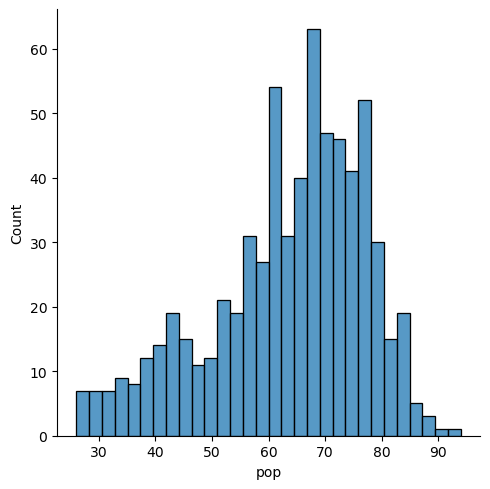

In [6]:
#histogram to show distribution of song popularity values
sns.displot(df['pop'], bins=30)
plt.show()

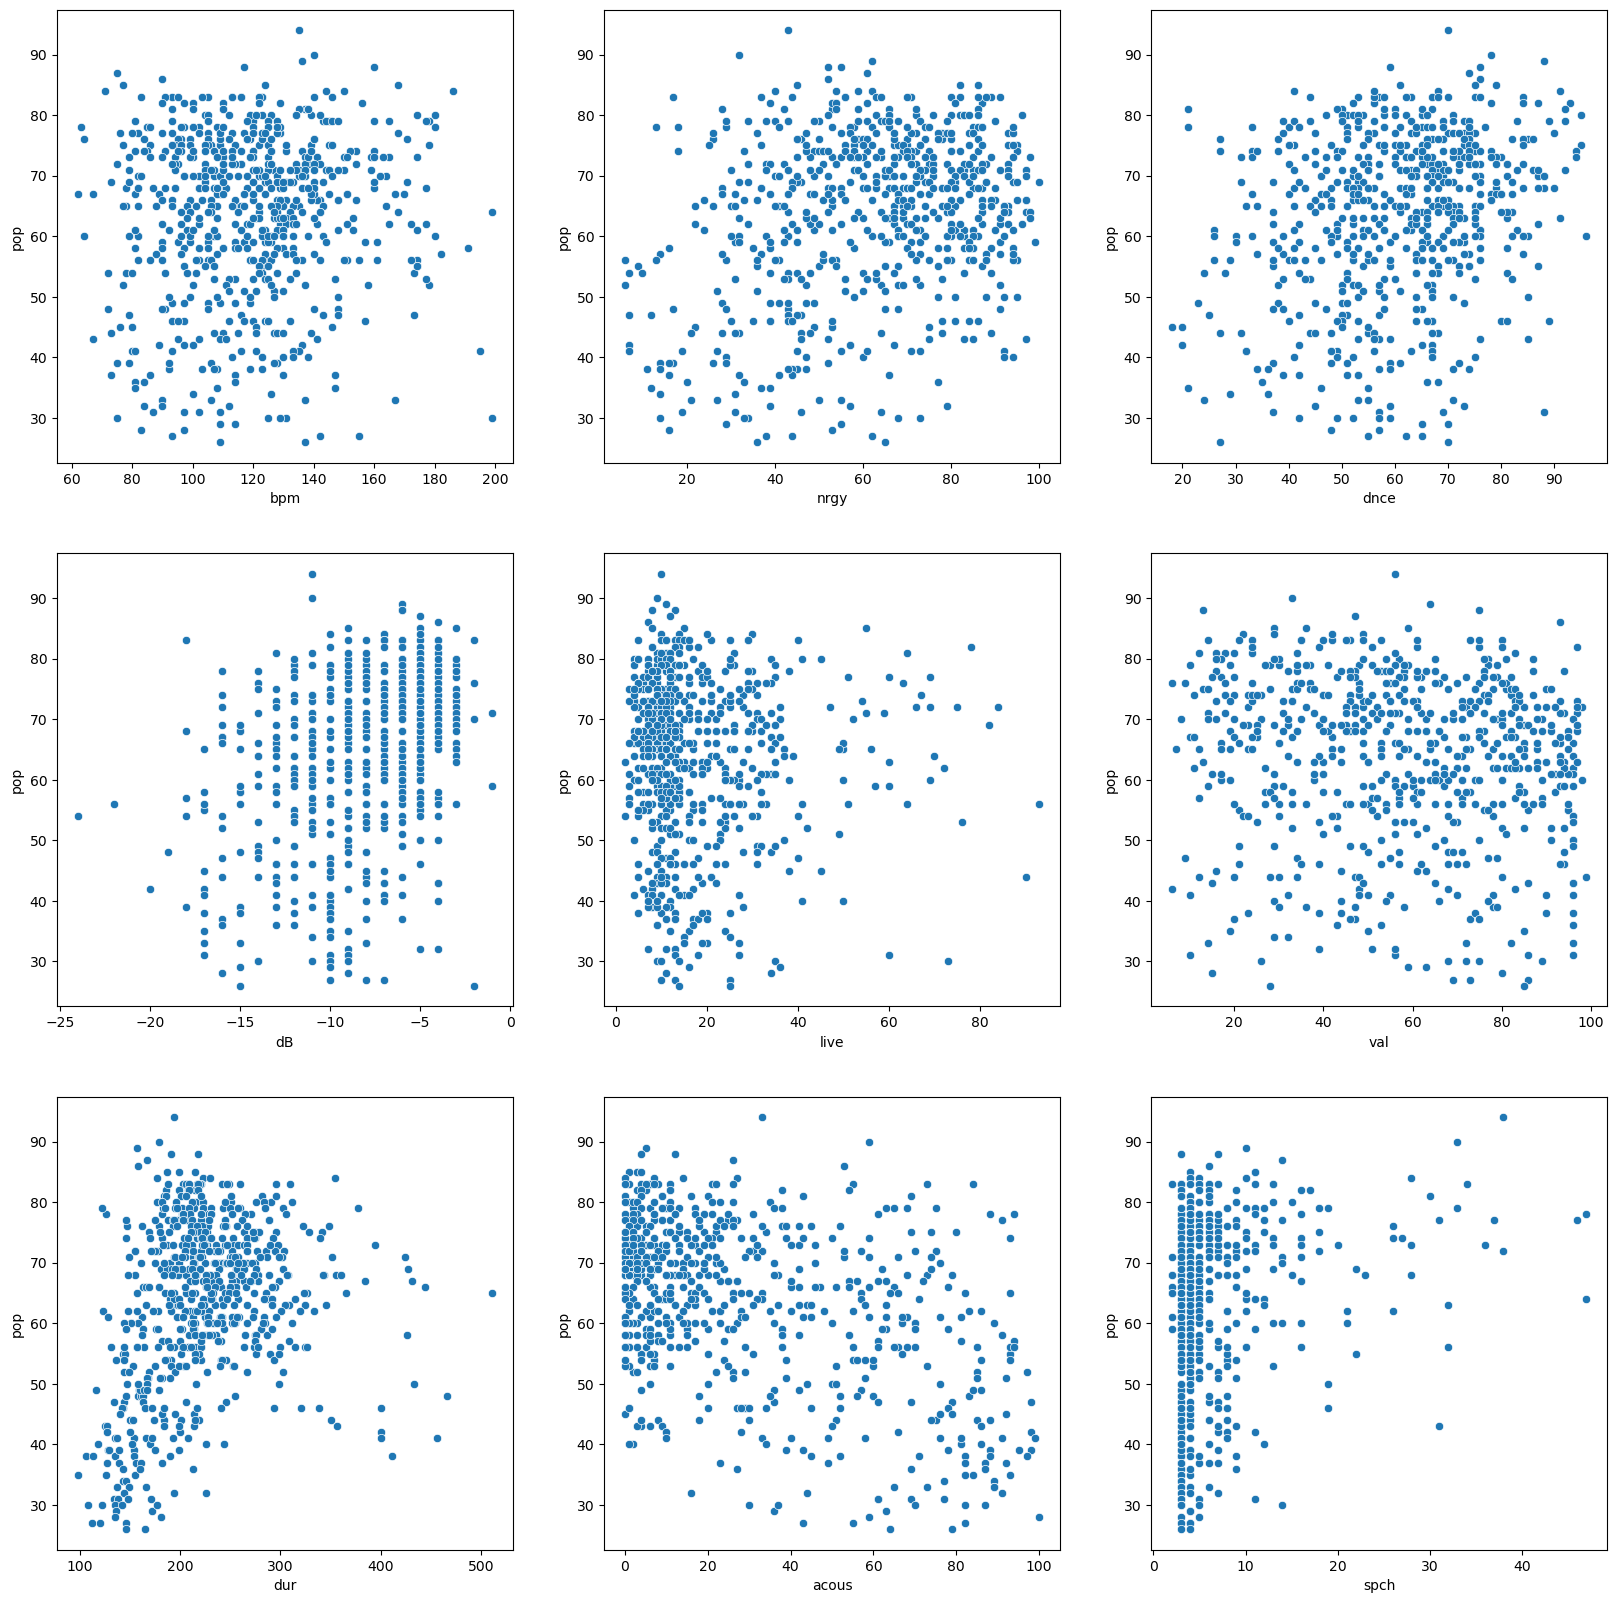

In [9]:
#visualizations of all numerical variables (including non-audial features) agaisnt song popularity
X = df[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']]
fig, axes = plt.subplots(3,3,figsize=(20,20))
p = 0
for i in range(3):
    for j in range(3):
        
        if p >= 9:
            break
        predictor = X.iloc[:,p]
        
        sns.scatterplot(ax=axes[i,j], x=predictor,y='pop',data=df)
        p+=1
plt.show()

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Forward Stepwise Variable Selection
*By Grant Li and Kegan Grace*

In [12]:
#Creating a dataframe with all the predictors
X = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]

# Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('pop~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}


#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model


def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    plt.show()

# Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

Processed  9 models on 1 predictors in 0.09870576858520508 seconds.
Processed  8 models on 2 predictors in 0.07076668739318848 seconds.
Processed  7 models on 3 predictors in 0.05678415298461914 seconds.
Processed  6 models on 4 predictors in 0.05843305587768555 seconds.
Processed  5 models on 5 predictors in 0.22335410118103027 seconds.
Processed  4 models on 6 predictors in 0.09517407417297363 seconds.
Processed  3 models on 7 predictors in 0.0477139949798584 seconds.
Processed  2 models on 8 predictors in 0.043982744216918945 seconds.
Processed  1 models on 9 predictors in 0.03317403793334961 seconds.
Total elapsed time: 0.7624890804290771 seconds.


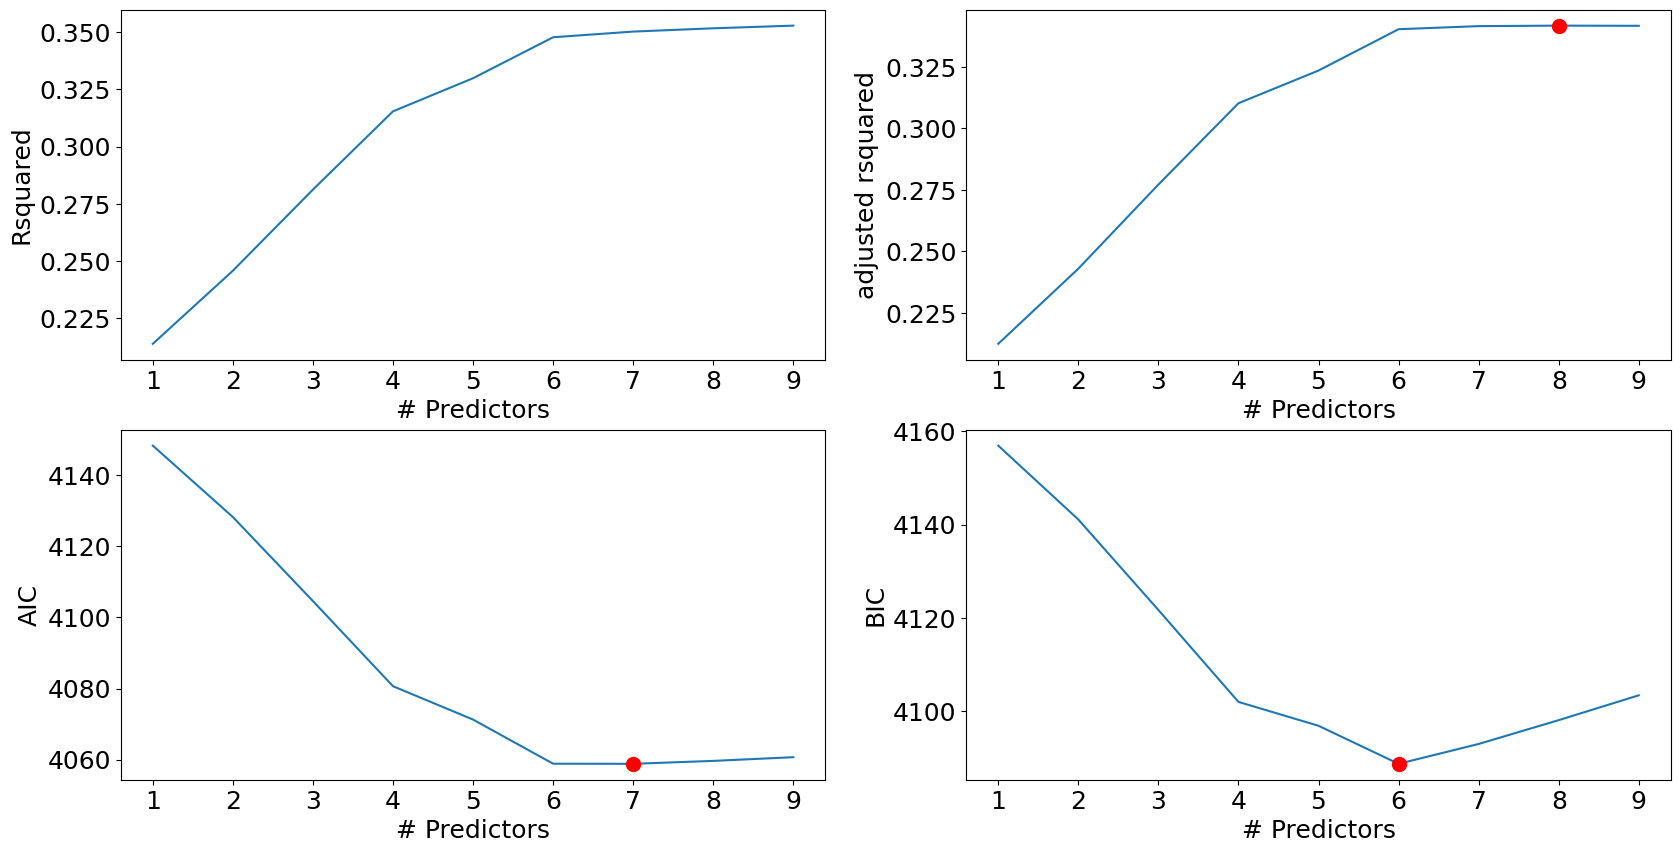

In [14]:
models_best = forward_selection()
best_sub_plots()

The optimal number of predictors is 6 according to BIC.

In [15]:
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     46.75
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           6.53e-46
Time:                        17:52:21   Log-Likelihood:                -2022.4
No. Observations:                 533   AIC:                             4059.
Df Residuals:                     526   BIC:                             4089.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5827      4.697     15.026      0.000      61.355      79.811
acous         -0.1697      0.024     -7.090      0.000      -0.217      -0.123
dur            0.0389      0.008      4.674      0.000       0.023       0.055
dB             1.0767      0.194      5.543      0.000       0.695       1.458
nrgy          -0.1181      0.041     -2.873      0.004      -0.199      -0.037
dnce           0.1801      0.038      4.742      0.000       0.105       0.255
val           -0.0961      0.025     -3.799      0.000      -0.146      -0.046
==============================================================================
Omnibus:                       11.190   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.409
Skew:                          -0.357   Prob(JB):                      0.00333
Kurtosis:                       3.068   Cond. No.                     2.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Testing - Transformations and Interactions
*By Nate Kim and Albert Wang*

In [21]:
# baseline model
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+val', data=train).fit()
print(model.summary())

#train MAE
pred_pop_train = model.predict(train)
mae_train = (np.abs(train['pop'] - pred_pop_train)).mean()
print("\nTrain MAE is",mae_train)
#test MAE
pred_pop_test = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop_test)).mean()
print("Test MAE is", mae)

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     46.75
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           6.53e-46
Time:                        17:59:57   Log-Likelihood:                -2022.4
No. Observations:                 533   AIC:                             4059.
Df Residuals:                     526   BIC:                             4089.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5827      4.697     15.026      0.0

#### Testing transformations on duration

In [20]:
#model with **2 transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(dur**2)', data=train).fit()
# print(model.summary())

#train MAE
pred_pop_train = model.predict(train)
mae_train = (np.abs(train['pop'] - pred_pop_train)).mean()
print("Train MAE with dur**2 is",mae_train)
#test MAE
pred_pop_test = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop_test)).mean()
print("Test MAE with dur**2 is", mae, '\n')


#model with log transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.log(dur))', data=train).fit()
# print(model.summary())

#train MAE
pred_pop_train = model.predict(train)
mae_train = (np.abs(train['pop'] - pred_pop_train)).mean()
print("Train MAE with log dur is",mae_train)
#test MAE
pred_pop_test = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop_test)).mean()
print("Test MAE with log dur is", mae, '\n')


# model with sqrt tranformation on dur
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.sqrt(dur))', data=train).fit()
# print(model.summary())

#train MAE
pred_pop_train = model.predict(train)
mae_train = (np.abs(train['pop'] - pred_pop_train)).mean()
print("Train MAE with sqrt dur is",mae_train)
#test MAE
pred_pop_test = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop_test)).mean()
print("Test MAE with sqrt dur is", mae)


Train MAE with dur**2 is 8.351061550499933
Test MAE with dur**2 is 10.070348273739508 

Train MAE with log dur is 8.212961734658453
Test MAE with log dur is 9.789270326253087 

Train MAE with sqrt dur is 8.23808893622631
Test MAE with sqrt dur is 9.856211168239046


In [42]:
# Adding interaction terms
df[['pop','acous','dB','dur','dnce','nrgy','val']].corr()

,pop,acous,dB,dur,dnce,nrgy,val
pop,1.000000,-0.455239,0.365172,0.280501,0.249302,0.271798,-0.102418
acous,-0.455239,1.000000,-0.504551,-0.227505,-0.382297,-0.665900,-0.196375
dB,0.365172,-0.504551,1.000000,0.026851,0.295534,0.702543,0.136813
dur,0.280501,-0.227505,0.026851,1.000000,0.053011,0.131228,-0.118664
dnce,0.249302,-0.382297,0.295534,0.053011,1.000000,0.331962,0.454714
nrgy,0.271798,-0.665900,0.702543,0.131228,0.331962,1.000000,0.405190
val,-0.102418,-0.196375,0.136813,-0.118664,0.454714,0.405190,1.000000


In [44]:
# improved model v2 - high correlation between acoustics and energy, and energy and db
model = model = smf.ols(formula='pop~nrgy*acous+nrgy*dB+dur+dnce+val+I(np.log(dur))', data=train).fit()
model.summary()
# test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print('Model 2 MAE: ', mae)

# improved model v3
model = model = smf.ols(formula='pop~acous*nrgy+dB+dur+dnce+val+I(np.log(dur))', data=train).fit()
model.summary()

pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print('Model 3 MAE: ', mae)

# improved model v4 
# Energy and danceability are intuitively related, so we tried an interaction term between them.
model_best = smf.ols(formula='pop~acous+dB+dur+nrgy*dnce+val+I(np.log(dur))', data=train).fit()

pred_pop = model_best.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print('Model 4 MAE: ', mae)
model_best.summary()

# this model (model v4) has the lowest mae, but one of the predictors isn't significant

Model 2 MAE:  9.587229952202062
Model 3 MAE:  9.669944695835968
Model 4 MAE:  9.632205410634889


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     45.52
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.97e-55
Time:                        18:18:00   Log-Likelihood:                -1995.7
No. Observations:                 533   AIC:                             4009.
Df Residuals:                     524   BIC:                             4048.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -252.3448     44.948     -5.614      0.000    -340.644    -164.045
acous             -0.1078      0.024     -4.409      0.000      -0.156      -0.060
dB                 0.9601      0.186      5.154      0.000       0.594       1.326
dur               -0.2426      0.042     -5.834      0.000      -0.324      -0.161
nrgy               0.1570      0.095      1.648      0.100      -0.030       0.344
dnce               0.4220      0.094      4.490      0.000       0.237       0.607
nrgy:dnce         -0.0045      0.001     -3.123      0.002      -0.007      -0.002
val               -0.0794      0.024     -3.245      0.001      -0.127      -0.031
I(np.log(dur))    68.4033      9.837      6.953      0.000      49.078      87.729
==============================================================================
Omnibus:                        8.968   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.020
Skew:                          -0.282   Prob(JB):                       0.0110
Kurtosis:                       3.297   Cond. No.                     4.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Code fitting the final model

*By Nate Kim*

In [22]:
model_best = smf.ols(formula='pop~acous+dB+dur+nrgy*dnce+val+I(np.log(dur))', data=train).fit()
print(model_best.summary())

#train MAE
pred_pop_train = model_best.predict(train)
mae_train = (np.abs(train['pop'] - pred_pop_train)).mean()
print("\nTrain MAE is",mae_train)
#test MAE
pred_pop_test = model_best.predict(test)
mae = (np.abs(test['pop'] - pred_pop_test)).mean()
print("Test MAE is", mae)

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     45.52
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.97e-55
Time:                        18:02:13   Log-Likelihood:                -1995.7
No. Observations:                 533   AIC:                             4009.
Df Residuals:                     524   BIC:                             4048.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -252.3448     44.948     -5.

### Testing Model Assumptions
*By Grant Li*

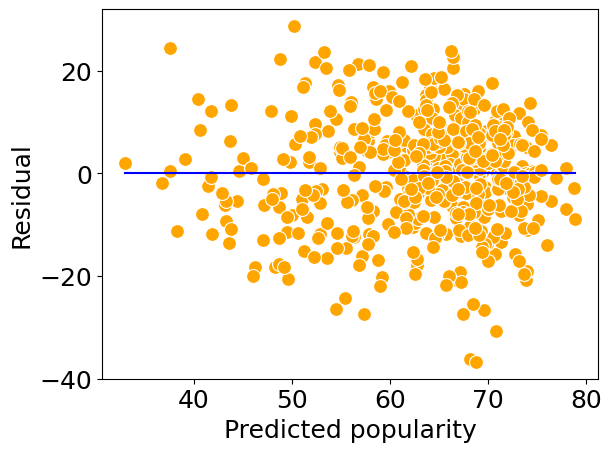

In [23]:
#outliers
pred_pop = model_best.predict(train)
sns.scatterplot(x=model_best.fittedvalues, y=model_best.resid, color='orange')
sns.lineplot(x=[pred_pop.min(),pred_pop.max()], y=[0,0],color='blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Residual')
plt.show()

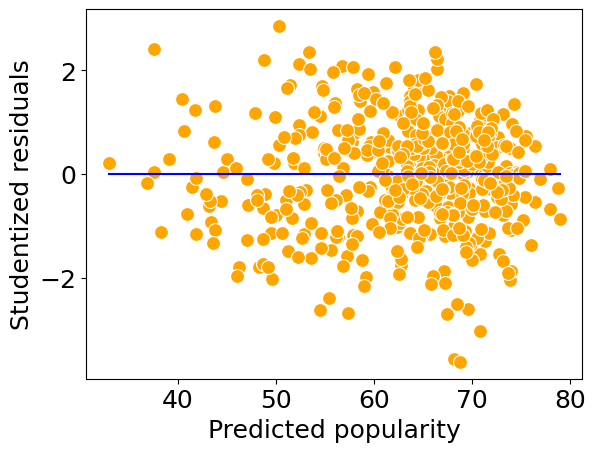

In [24]:
out = model_best.outlier_test()
# returns a df w the first col as studentized residuals
# res plot, this time w studentized residuals
sns.scatterplot(x=model_best.fittedvalues, y = out.student_resid, color='orange')
sns.lineplot(x = [model_best.fittedvalues.min(),model_best.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Studentized residuals')
plt.show()

In [25]:
print(np.sum(np.abs(out.student_resid) > 3)) # 3 outliers

3


In [26]:
# leverage calculations
influence = model_best.get_influence()
leverage = influence.hat_matrix_diag
cutoff = 4*(model_best.df_model+1)/model_best.nobs
print(np.sum(leverage>cutoff)) #6 high leverage points

6


In [27]:
#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>cutoff)[0])))
train_filtered.shape[0]-train.shape[0]
#no influential points

0

### Regularization
*By Nate Kim and Albert Wang*

In [28]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [29]:
#lasso
X = train[['acous','dB','dur','nrgy','dnce','val']]
X['nrgy*dnce'] = X['nrgy']*X['dnce']
X['I(np.log(dur))'] = np.log(X['dur'])

# let us develop a lasso model to predict pop based on the predictors in model_best

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

/var/folders/78/287t_xwn4jj_fts7vlrhv3z80000gq/T/ipykernel_21184/325638881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['nrgy*dnce'] = X['nrgy']*X['dnce']
/var/folders/78/287t_xwn4jj_fts7vlrhv3z80000gq/T/ipykernel_21184/325638881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['I(np.log(dur))'] = np.log(X['dur'])


In [30]:
y = train['pop']
alphas = 10**np.linspace(10,-2,100)*0.1
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

In [34]:
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

5.484928989461909e-06

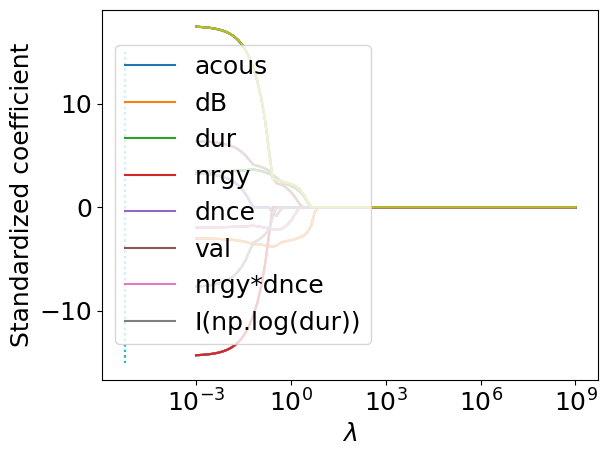

In [37]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(X)
plt.plot([lassocv.alpha_,lassocv.alpha_],[-15,15],':')
plt.legend(X)
plt.show()

In [38]:
Xtest = test[['acous','dB','dur','nrgy','dnce','val']]
Xtest['nrgy*dnce'] = Xtest['nrgy']*Xtest['dnce']
Xtest['I(np.log(dur))'] = np.log(Xtest['dur'])

Xtest_std = scaler.transform(Xtest)

/var/folders/78/287t_xwn4jj_fts7vlrhv3z80000gq/T/ipykernel_21184/1475412427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['nrgy*dnce'] = Xtest['nrgy']*Xtest['dnce']
/var/folders/78/287t_xwn4jj_fts7vlrhv3z80000gq/T/ipykernel_21184/1475412427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['I(np.log(dur))'] = np.log(Xtest['dur'])


In [39]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [41]:
# Calculate test MAE on regularized model
mae = (np.abs(test['pop'] - pred)).mean()
print('Regularized test MAE: ', mae)

Regularized test MAE:  9.632210796802893


In [40]:
best_coeffs = lasso.coef_

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.